In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.sparse import diags
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
plt.rcParams.update({'font.size': 14})

def calcvelocity(rrange,sigma,vdiff,A,vmin):         #Calculate the introduced velocity profile
    sigmaterm = sigma**2
    distances = np.linspace(0,rrange,Nx)
    I = A*np.exp(-distances**2/sigmaterm)
    return distances, vactive*vdiff*np.exp(-I/A)+vmin, I

def normalize(inn):                                  #normalize the input curve to 1
    return inn/(sum(inn)*dx)

def calcvelocitysingle(rvalue,sigma,vdiff,A,vmin):   #Calculate the introduced velocity profile at a single position
    sigmaterm = sigma**2
    I = A*np.exp(-rvalue**2/sigmaterm)
    return vdiff*np.exp(-I/A)+vmin

def MSD(t,D,V,taur):                    #Calculate the steplength
    return 4*D*t+V**2*taur**2/2*(2*t/taur+np.exp(-2*t/taur)-1)

def steplengththeory(t,v,taur):
    return v*t*(1-t/taur)

# Initial parameters for theory

In [15]:
amplitude = 1                    #Amplitude, always 1
vmin = 0                         #Min velocity
vmax = 1                         #Max velocity
pxtomum=0.0533#e-6               #px to µm [µm/px]
sigma = 50*pxtomum               #Sigma for the Gaussian intensity profile [px]
D_0 = 3.85e-14*1e12              #measured diffusion coefficient D_0 = kB*T/(6*np.pi*eta*radius)
boundaryradius = pxtomum * 200   #Size of the arena
vactive = 6                      #Active velocity

videosize = 800                  #size of the movie
programtime = 3                  #time of the program (tracking + calculation) [s]
iterationtime = 51.9986          #iteration time in ms

delayincrease = 4                #delay increase per step
taur = 0.65#1                    #Reorientation time
vprofilesteps = 50               #radial start points                               
steps = 180                       #angular steps
number = 10                      #delay steps
boundaryparameter = 0.5          #parameter defining the strength of the influence of the boundary bounce
driftparameter = 1             #parameter defining the strength of the drift

# Perform theory

In [16]:
vdiff = vmax - vmin
addtime = videosize*1.9176e-6+(1032/27e6+1.9176e-6)*videosize+programtime*1e-3+1e-3*2
dt = iterationtime*1e-3
onestep = 360/steps
rwave = np.linspace(0,boundaryradius,vprofilesteps,endpoint=True)
dx = rwave[1] - rwave[0]
maxdelay = 1+delayincrease*number
values = np.zeros(number); delayarray = np.zeros(number)
for i in range(number):                  #calculate the delay for the different steps
    values[i] = 1 + delayincrease*i
    delayarray[i] = iterationtime*1e-3*(values[i]-1)+dt/2+videosize*1.9176e-6+(1032/27e6+1.9176e-6)*videosize+programtime*1e-3+1e-3*2 

everystep = np.zeros((maxdelay,vprofilesteps,steps,4))                    #every step on the path to the past position is saved
importantsteps = np.zeros((number,vprofilesteps,steps,4))                 #just the steps of the wanted delays are saved
everystep[0,:,:,0] = 0
for i in range(vprofilesteps): everystep[0,i,:,1] = rwave[i]              #radial startposition
for i in range(steps): everystep[:,:,i,2] = onestep*i                     #angular startposition
for i in range(vprofilesteps):
    for j in range(steps):
        count = 0
        for p in range(1,maxdelay+1):
            dist = np.sqrt(pow(everystep[p-1,i,j,0],2)+pow(everystep[p-1,i,j,1],2))    #dist to center for every position
            if dist >= boundaryradius:                                                 #boundary condition - reflexion of v-profile
                dist = 2*boundaryradius - boundaryparameter*dist                       #v-profile is mirrored at the boundary
            everystep[p-1,i,j,3] = vactive*calcvelocitysingle(dist,sigma,vdiff,amplitude,vmin)  #calculate v for every position
            step = steplengththeory(dt,everystep[p-1,i,j,3],taur)                  #caclculate step length for every position
            if p < maxdelay:
                everystep[p,i,j,0] = everystep[p-1,i,j,0] + np.cos(everystep[p-1,i,j,2]*np.pi/180)*step   #calculate new position
                everystep[p,i,j,1] = everystep[p-1,i,j,1] + np.sin(everystep[p-1,i,j,2]*np.pi/180)*step
            if count < number:                                           #save just important steps
                if p-1 == values[count]:
                    importantsteps[count,i,j,:4] = everystep[p-1,i,j,:4]
                    count += 1
                
vprofiles = np.zeros((number,vprofilesteps,4))
for i in range(number):
    for j in range(vprofilesteps):
        vprofiles[i,j,0] = np.mean(importantsteps[i,j,:,3])                        #calculate v profile
        vprofiles[i,j,1] = np.mean(importantsteps[i,j,int(vprofilesteps/2):,3])    #v moving outwards
        vprofiles[i,j,2] = np.mean(importantsteps[i,j,:int(vprofilesteps/2),3])    #v moving inwards
        vprofiles[i,j,3] = vprofiles[i,j,2] - vprofiles[i,j,1]                     #v difference
        
savedensity2 = np.zeros((vprofilesteps,number))             #solve the ODe to get the density from the D- and v_diff profiles
for k in range(number):
    Darray = np.zeros(vprofilesteps)
    Darray = D_0+vprofiles[k,:,0]**2*taur/4# + D_0
    c = np.zeros(vprofilesteps)                             #array to save the density distributions
    c[0] = 1
    for i in range(0,vprofilesteps-1):
        #c[i+1] = c[i] * (1 - (Darray[i+1]-Darray[i]) / (2*Darray[i]))
        #c[i+1] = c[i] * (1 - (Darray[i+1]-Darray[i]) / (2*(Darray[i]-vprofiles[k,i,3]**2*taur)))
        c[i+1] = c[i] * (1 - dx/Darray[i]*((Darray[i+1]-Darray[i])/(2*dx)+driftparameter*vprofiles[k,i,3]))
        c[:] = c[:]/sum(abs(c[:])*dx)                       #Normalize
    savedensity2[:,k] = c                                   #saveit
    
maxpoints = np.zeros((number,2))
for i in range(number):                                     #find and save maximum points of the drift for every delay
    maxpoints[i,1] = max(vprofiles[i,:,3])
    check = np.argmax(vprofiles[i,:,3])
    maxpoints[i,0] = rwave[check]

# Plot results from theory

<ipython-input-17-a451dd956917>:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


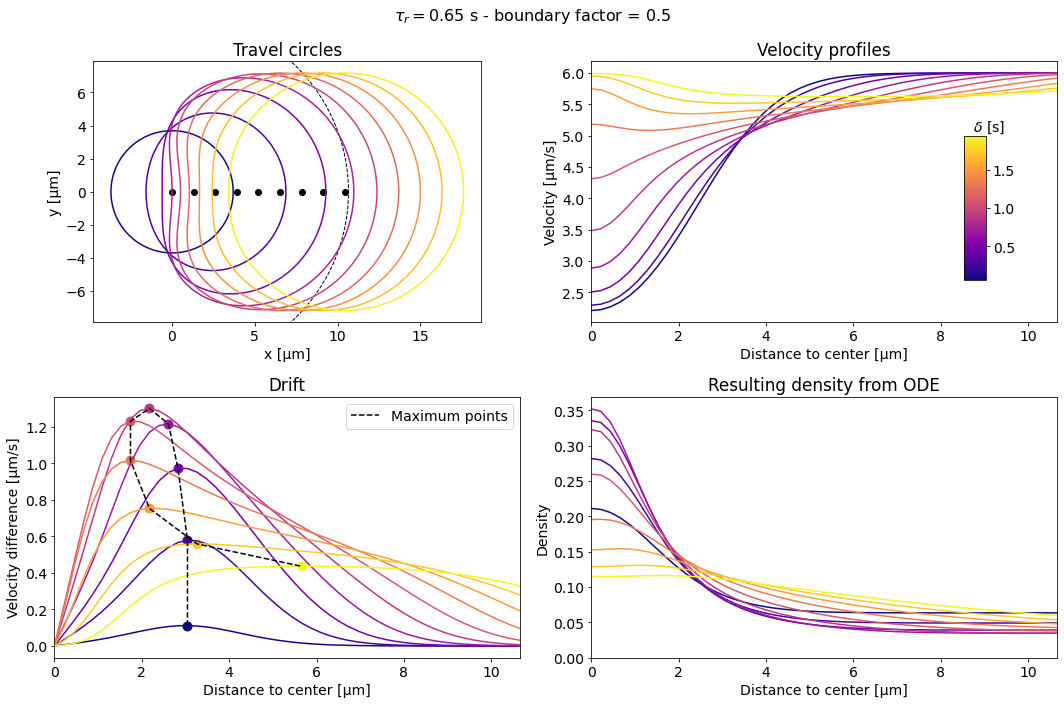

In [17]:
fig, ax = plt.subplots(figsize=(15,10)) 
fig.suptitle(r'$\tau_{r} = $'+str(taur)+' s - boundary factor = '+str(boundaryparameter), fontsize=16)

ax1 = plt.subplot(2,2,1)                  #plot rings
colorwave = cm.plasma(np.linspace(0, 1, vprofilesteps))
circle2 = plt.Circle((0, 0), boundaryradius, color='k',linestyle='--', fill=False)
ax1.add_artist(circle2)
test = 6
for i in range(vprofilesteps):
    if i % 6 == 0:
        ax1.scatter(rwave[i],0,color='k')
        ax1.plot(importantsteps[test,i,:,1],importantsteps[test,i,:,0],c=colorwave[i])
        ax1.plot([importantsteps[test,i,-1,1],importantsteps[test,i,0,1]],[importantsteps[test,i,-1,0],importantsteps[test,i,0,0]],c=colorwave[i])
ax1.set_aspect('equal')
value = 1.1*boundaryradius
#ax1.set_xlim(-3,value)
#ax1.set_ylim(-8,8)
ax1.set_xlabel('x [µm]')
ax1.set_ylabel('y [µm]')
ax1.set_title('Travel circles')
        
ax2 = plt.subplot(2,2,2)                  #plotv profiles
colorwave = cm.plasma(np.linspace(0, 1, number))
for i in range(number): ax2.plot(rwave,vprofiles[i,:,0],color=colorwave[i],label = 'delay = '+str(round(delayarray[i],2))+'s')
ax2.set_xlabel('Distance to center [µm]')
ax2.set_ylabel('Velocity [µm/s]') 
ax2.set_title('Velocity profiles')
ax2.set_xlim(0,boundaryradius)

data = np.linspace(delayarray[0], delayarray[-1], number).reshape(number, 1)
im = ax.imshow(data, cmap='plasma')       #plot the colorbar
divider = make_axes_locatable(ax2)
cax = fig.add_axes([0.9, 0.6, 0.02, 0.2])
plt.colorbar(im, cax=cax)
plt.text(0.8,2,r'$\delta$ [s]')

ax3 = plt.subplot(2,2,3)                  #plot v_diff and maximum points                                                                     
for i in range(number):
    ax3.plot(rwave,vprofiles[i,:,3],color=colorwave[i])
    ax3.scatter(maxpoints[i,0],maxpoints[i,1],s=80,color=colorwave[i])
ax3.plot(maxpoints[:,0],maxpoints[:,1],color='k',linestyle='--',label = 'Maximum points')
ax3.set_xlabel('Distance to center [µm]')
ax3.set_ylabel('Velocity difference [µm/s]')
ax3.set_title('Drift')
ax3.set_xlim(0,boundaryradius)
ax3.legend()

ax4 = plt.subplot(2,2,4)                  #plot resulting density distributions
for i in range(number): ax4.plot(rwave,savedensity2[:,i],c=colorwave[i])
ax4.set_xlabel('Distance to center [µm]')
ax4.set_ylabel('Density') 
ax4.set_title('Resulting density from ODE')
ax4.set_xlim(0,boundaryradius)
ax4.set_ylim([0,1.05*np.amax(savedensity2)])
        
plt.tight_layout() 
plt.savefig('Overview - boundary factor = '+str(boundaryparameter)+'.pdf', format='pdf')
plt.savefig('Overview - boundary factor = '+str(boundaryparameter)+'.svg', format='svg')
plt.show()

# Load and analyze experiment data

In [18]:
filestart = '1'
fileend = '50'
folder = './DataExperiment'

datageneral = np.loadtxt(r''+str(folder)+'/DataGeneral'+str(filestart)+'.txt')
dt = datageneral[0]
videosize = datageneral[3]
binning = 1
frametransfer = False
flashtime = 0.01
verticalshift = 1.9176e-6
dtprogram = 6.3e-3
dtcamtoPC = 1e-3
dtPCtoADwin = 1e-3

folder = './DataExperiment/DataImportant'     #Load from that folders
folder3 = './DataExperiment/DataRadial'
num = int(fileend)-int(filestart)+1
dataimportant = np.loadtxt(r''+str(folder)+'/DataImportant'+str(filestart)+'.txt')
lengthimportant = len(dataimportant)        #initialize size of the arrays
expallimportant = np.zeros((lengthimportant,num))          
data4 = np.loadtxt(r''+str(folder3)+'/DataRadial'+str(filestart)+'.txt')
radiallength = len(data4)
radialrows = len(data4[0,:])
expdataradial = np.zeros((radiallength,radialrows,num))

for i in range(num):                          #Load data
    if i < 36: file = int(int(filestart)+i)
    else: file = int(int(filestart)+i+1)
    data2 = np.loadtxt(r''+str(folder)+'/DataImportant'+str(file)+'.txt')
    #0 - mean distance to center, 1 - boundary hits, 2 - mean angle change, 3 - countin, 4 - noise, 5 - delay, 
    #6 - reorientation time, 7 - mean of the propability, 8 - sd density, 9/10 - Drot/err, 11/12 - Drotexp/err, 
    #13/14 - ptime/err, 15/16 - plength/err, 17/18 - radialdistmore in/out, 19 vmax, 
    #20 meantime, 21 meanprob, 22 notone, 23 zero 
    expallimportant[:,i] = data2

    #0 - xpos; 1 - mean v; 2 - std v; 3 - mean v_out; 4 - std v_out; 5 - mean v_in; 6 - std v_in
    #7 - density; 8 - v diff; 9 - v diff std; 10 - Drift; 11 - std Drift; 12 - % inwards; 13 - N*v_in - N * v_out
    data4 = np.loadtxt(r''+str(folder3)+'/DataRadial'+str(file)+'.txt')
    expdataradial[:,:,i] = data4

expallimportant[5,6] = 25                      #Correct some wrong saved data
expallimportant[5,7] = 29 
expallimportant[5,12] = 9 
expallimportant[5,36:39] -= 1
expallimportant[5,40:49] -= 1
expallimportant[4,39] = 17
    
rows = 1; expsteps = 1; check = True
for i in range(1,num):
    if check == True:
        if expallimportant[4,i] == expallimportant[4,i-1]: expsteps += 1
    if expallimportant[4,i] != expallimportant[4,i-1]:
            check = False
            rows += 1
print('steps = ',expsteps,' - rows = ',rows)
dtframetransfer = videosize/binning * verticalshift          #Calculate delay
dtreadout = (1032/27e6+verticalshift)*videosize/binning
dtexphalf = flashtime/2
dttotal = dtexphalf + dtframetransfer + dtreadout + dtcamtoPC + dtprogram + dtPCtoADwin
delaytest = np.zeros(num)
for i in range(num): delaytest[i] = dttotal + (expallimportant[5,i]-1)*dt
timewave = np.zeros(num)
for i in range(num): timewave[i] = 51e-3*10000*i/(60*60) 
    
test = np.linspace(0,boundaryradius,radiallength+1)
radius = np.zeros(radiallength)
for i in range(radiallength): expdataradial[i,0,:] = (test[i]+test[i+1])/2
    
expmeandrot = np.zeros(num)                                  #Calculate average tau_r
for i in range(rows):
    with warnings.catch_warnings():
        warnings.simplefilter("error")
        try: expmeandrot[i*expsteps:i*expsteps+expsteps] = stat.mode(expallimportant[6,i*expsteps:i*expsteps+expsteps])
        except: expmeandrot[i*expsteps:i*expsteps+expsteps] = np.nanmean(expallimportant[6,i*expsteps:i*expsteps+expsteps])
            
comparearray = np.zeros(rows); expdelaywave = np.zeros(expsteps)  #Save average tau_r
for i in range(rows): comparearray[i] = abs(expmeandrot[i*expsteps]-taur)
for i in range(expsteps): expdelaywave[i] = delaytest[i]
expfittingrow = np.argmin(comparearray)

expsmoothflow = np.zeros((radiallength,number))              #Smooth v_diff from experiment
count = expfittingrow*expsteps
for i in range(number):
    expsmoothflow[0,i] = (expdataradial[0,8,count] + 0.5*expdataradial[1,8,count])/1.5
    expsmoothflow[-1,i] = (0.5*expdataradial[-2,8,count] + expdataradial[-1,8,count])/1.5
    for j in range(1,radiallength-1): expsmoothflow[j,i] = (0.5*expdataradial[j-1,8,count]+expdataradial[j,8,count]+0.5*expdataradial[j+1,8,count])/2
    count += 1

expmaxpoints = np.zeros((number,2))                          #Find extremas of v_diff
count = expfittingrow*expsteps
for i in range(number):
    expmaxpoints[i,1] = np.max(expsmoothflow[1:-1,i])
    check = np.argmax(expsmoothflow[1:-1,i])
    expmaxpoints[i,0] = expdataradial[check+1,0,0]
    count += 1

test = np.linspace(0,boundaryradius,radiallength+1)          #Correct radial position
radius = np.zeros(radiallength)
for i in range(radiallength): expdataradial[i,0,:] = (test[i]+test[i+1])/2

expdensity = np.zeros(expsteps)                              #Calculate the percentage the particle spends in the inner quarter
expdx = expdataradial[1,0,0] - expdataradial[0,0,0]
count = expfittingrow*expsteps
for i in range(expsteps):
    expdensity[i] = sum(expdataradial[:3,7,count]*expdx)/sum(expdataradial[:,7,count]*expdx)
    count += 1

steps =  10  - rows =  5


# Load and analyze data from numerical simulation

In [19]:
start = '0'
end = '49'
folder = './DataSimulation/DataImportant'          #Load from that folders
folder2 = './DataSimulation/DataRadial'
num = int(end)-int(start)+1

data3 = np.loadtxt(r''+str(folder)+'/DataImportant'+str(start)+'.txt')
importantlength = len(data3)                       #Initialize arrays
simallimportant = np.zeros((importantlength,num))           

data4 = np.loadtxt(r''+str(folder2)+'/DataRadial'+str(start)+'.txt')
radiallength = len(data4)
radialrows = len(data4[0,:])
simdataradial = np.zeros((radiallength,radialrows,num))

for i in range(num):                               #Load data
    number2 = int(int(start)+i)
    data2 = np.loadtxt(r''+str(folder)+'/DataImportant'+str(number2)+'.txt')
    #0 - mean distance         1 - paths  2 - angle change; 3 - inside; 4 - noise; 5 - delay; 6 - tau_r; 
    #7 - mean rho; 8 - tau_r 2; 9/10 - Drot/err; 11/12 - Drot2/err; 13/14 - ptime/err; 15/16 - rlength/err; 
    #17/18 - morein/out; 19 - maxv; 20 - meantime; 21 - meanprob
    simallimportant[:,i] = data2
    
    #0 - xpos; 1 - mean v; 2 - std v; 3 - mean v_out; 4 - std v_out; 5 - mean v_in; 6 - std v_in
    #7 - density; 8 - v diff; 9 - v diff std; 10 - Drift; 11 - std Drift; 12 - % inwards; 13 - N*v_in - N * v_out
    data4 = np.loadtxt(r''+str(folder2)+'/DataRadial'+str(number2)+'.txt')
    simdataradial[:,:,i] = data4

rows = 1; simsteps = 1; check = True
for i in range(1,num):
    if check == True:
        if simallimportant[4,i] == simallimportant[4,i-1]: simsteps += 1
    if simallimportant[4,i] != simallimportant[4,i-1]:
            check = False
            rows += 1
print('steps = ',simsteps,' - rows = ',rows)

delaytest = np.zeros(num)                           #Calculate delay
for i in range(num): delaytest[i] = iterationtime*1e-3*(simallimportant[5,i]-1)+dt/2+videosize*1.9176e-6+(1032/27e6+1.9176e-6)*videosize+programtime*1e-3+1e-3*2       
simtimewave = np.zeros(num)
for i in range(num): simtimewave[i] = 51e-3*10000*i/(60*60) 
    
simmeandrot = np.zeros(num)                         #Calculate average tau_R
for i in range(rows):
    with warnings.catch_warnings():
        warnings.simplefilter("error")
        try: simmeandrot[i*simsteps:i*simsteps+simsteps] = stat.mode(simallimportant[6,i*simsteps:i*simsteps+simsteps])
        except: simmeandrot[i*simsteps:i*simsteps+simsteps] = np.mean(simallimportant[6,i*simsteps:i*simsteps+simsteps])

comparearray = np.zeros(rows); simdelaywave = np.zeros(simsteps)
for i in range(rows): comparearray[i] = abs(simmeandrot[i*simsteps]-taur)
for i in range(simsteps): simdelaywave[i] = delaytest[i]
simfittingrow = np.argmin(comparearray)

test = np.linspace(0,boundaryradius,radiallength+1)
radius = np.zeros(radiallength)
for i in range(radiallength): simdataradial[i,0,:] = (test[i]+test[i+1])/2
    
simmaxpoints = np.zeros((number,2))          #Find the maximum points of the flow
count = simfittingrow*simsteps
for i in range(number):
    simmaxpoints[i,1] = np.max(simdataradial[:,8,count])
    check = np.argmax(simdataradial[:,8,count])
    simmaxpoints[i,0] = simdataradial[check,0,count]
    count += 1

dataend = (expdataradial[3,0,0] + expdataradial[2,0,0])/2 #mittel zwischen 2-3    
count = 0; check = True
while check == True:
    if simdataradial[count,0,0] >= dataend: 
        check = False
        simend = count
    else: count += 1
simdensity = np.zeros(simsteps)                           #Calculate the percentage the particle spends in the inner quarter
simdx = simdataradial[1,0,0] - simdataradial[0,0,0]       #Simulation
count = simfittingrow*simsteps
for i in range(simsteps):
    simdensity[i] = sum(simdataradial[:3,7,count]*simdx)/sum(simdataradial[:,7,count]*simdx)
    count += 1
    
theodensity = np.zeros(number)                            #Calculate the percentage the particle spends in the inner quarter
count = 0; check = True                                   #Theory
while check == True:
    if rwave[count] >= dataend: 
        check = False
        theoend = count
    else: count += 1
for i in range(number): theodensity[i] = sum(savedensity2[:theoend,i]*dx)/sum(savedensity2[:,i]*dx)

steps =  10  - rows =  5


# Plot comparision between theory, simulation and experiment

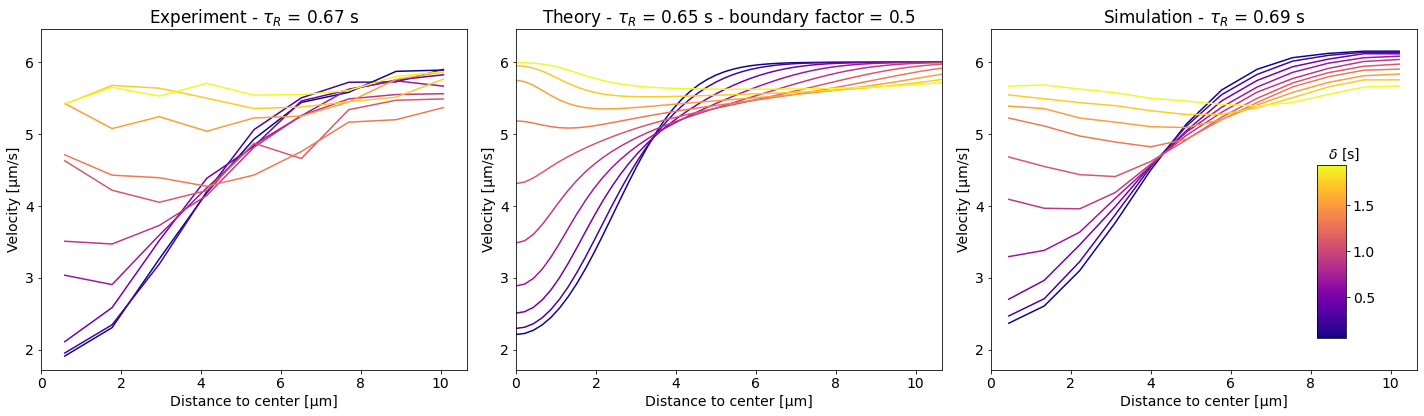

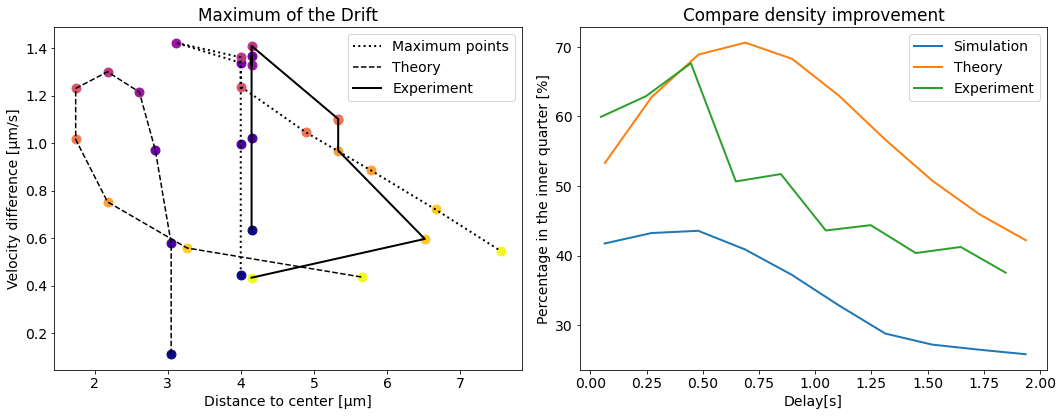

In [20]:
extremaarray = np.zeros((3,2))
extremaarray[0,0] = np.amin(expdataradial[:,1,expfittingrow*expsteps:expfittingrow*expsteps+expsteps])
extremaarray[1,0] = np.amin(simdataradial[:,1,simfittingrow*simsteps:simfittingrow*simsteps+simsteps])
extremaarray[2,0] = np.amin(vprofiles[:,:,0])
extremaarray[0,1] = np.amax(expdataradial[:,1,expfittingrow*expsteps:expfittingrow*expsteps+expsteps])
extremaarray[1,1] = np.amax(simdataradial[:,1,simfittingrow*simsteps:simfittingrow*simsteps+simsteps])
extremaarray[2,1] = np.amax(vprofiles[:,:,0])
minvalue = 0.9*np.min(extremaarray[:,0])
maxvalue = 1.05*np.max(extremaarray[:,1])

fig, ax = plt.subplots(figsize=(20,6)) 
#fig.suptitle('Compare velocity profiles', fontsize=26)
ax1 = plt.subplot(1,3,1)
colorwave = cm.plasma(np.linspace(0, 1, expsteps))
count = expfittingrow*expsteps
for i in range(expsteps):
    ax1.plot(expdataradial[:,0,count],expdataradial[:,1,count],color=colorwave[i])
    count += 1
ax1.set_xlabel('Distance to center [µm]')
ax1.set_ylabel('Velocity [µm/s]') 
ax1.set_xlim([0,boundaryradius])
ax1.set_ylim([minvalue,maxvalue])
ax1.set_title(r'Experiment - $\tau_{R}$ = '+str(round(expmeandrot[expfittingrow*expsteps],2))+' s')
                            
ax2 = plt.subplot(1,3,2)
colorwave = cm.plasma(np.linspace(0, 1, number))
for i in range(number):
    ax2.plot(rwave,vprofiles[i,:,0],color=colorwave[i])
ax2.set_xlabel('Distance to center [µm]')
ax2.set_ylabel('Velocity [µm/s]') 
ax2.set_xlim([0,boundaryradius])
ax2.set_ylim([minvalue,maxvalue])
ax2.set_title(r'Theory - $\tau_{R}$ = '+str(taur)+' s - boundary factor = '+str(boundaryparameter))

ax3 = plt.subplot(1,3,3)
colorwave = cm.plasma(np.linspace(0, 1, simsteps))
count = simfittingrow*simsteps
for i in range(number):
    ax3.plot(simdataradial[:,0,count],simdataradial[:,1,count],color=colorwave[i])
    count += 1
ax3.set_xlabel('Distance to center [µm]')
ax3.set_ylabel('Velocity [µm/s]') 
ax3.set_xlim([0,boundaryradius])
ax3.set_ylim([minvalue,maxvalue])
ax3.set_title(r'Simulation - $\tau_{R}$ = '+str(round(simmeandrot[simfittingrow*simsteps],2))+' s')

plt.tight_layout() 
data = np.linspace(simdelaywave[0], simdelaywave[-1], number).reshape(number, 1)
im3 = ax.imshow(data, cmap='plasma')
divider = make_axes_locatable(ax3)
cax3 = fig.add_axes([0.92, 0.2, 0.02, 0.4])
plt.colorbar(im3, cax=cax3)
plt.text(0.8,2,r'$\delta$ [s]')
plt.savefig('Fig7.pdf', format='pdf')
plt.savefig('Compare velocity profiles.pdf', format='pdf')
plt.savefig('Compare velocity profiles.svg', format='svg')
plt.show()

fig, ax = plt.subplots(figsize=(15,6)) 
ax1 = plt.subplot(1,2,1)      
count = simfittingrow*simsteps
for i in range(number):
    #ax1.plot(rwave,vprofiles[i,:,3],color=colorwave[i])
    ax1.scatter(maxpoints[i,0],maxpoints[i,1],s=80,color=colorwave[i])
    #ax1.plot(simdataradial[:,0,count],simdataradial[:,8,count],color=colorwave[i])
    ax1.scatter(simmaxpoints[i,0],simmaxpoints[i,1],s=80,color=colorwave[i])
    #ax1.plot(expdataradial[:,0,count],expsmoothflow[:,i],color=colorwave[i])
    ax1.scatter(expmaxpoints[i,0],expmaxpoints[i,1],s=80,color=colorwave[i])    
    count += 1
ax1.plot(simmaxpoints[:,0],simmaxpoints[:,1],color='k',linestyle='dotted',label = 'Maximum points',linewidth=2)    
ax1.plot(maxpoints[:,0],maxpoints[:,1],color='k',linestyle='--',label = 'Theory')
ax1.plot(expmaxpoints[:,0],expmaxpoints[:,1],color='k',label = 'Experiment',linewidth=2)

ax1.set_xlabel('Distance to center [µm]')
ax1.set_ylabel('Velocity difference [µm/s]')
#ax1.set_xlim([0,boundaryradius])
ax1.set_title('Maximum of the Drift')
ax1.legend()

ax2 = plt.subplot(1,2,2)
ax2.plot(simdelaywave,simdensity*100,linewidth=2,label='Simulation')
ax2.plot(delayarray,theodensity*100,linewidth=2,label='Theory')
ax2.plot(expdelaywave,expdensity*100,linewidth=2,label='Experiment')
ax2.set_xlabel('Delay[s]')
ax2.set_ylabel('Percentage in the inner quarter [%]')
ax2.set_title('Compare density improvement')
ax2.legend()

plt.tight_layout()
plt.savefig('Fig8.pdf', format='pdf')
plt.savefig('Compare flow and density - boundary factor = '+str(boundaryparameter)+'.pdf', format='pdf')
plt.savefig('Compare flow and density - boundary factor = '+str(boundaryparameter)+'.svg', format='svg')
plt.show()

# Creating figures for the Latex Script

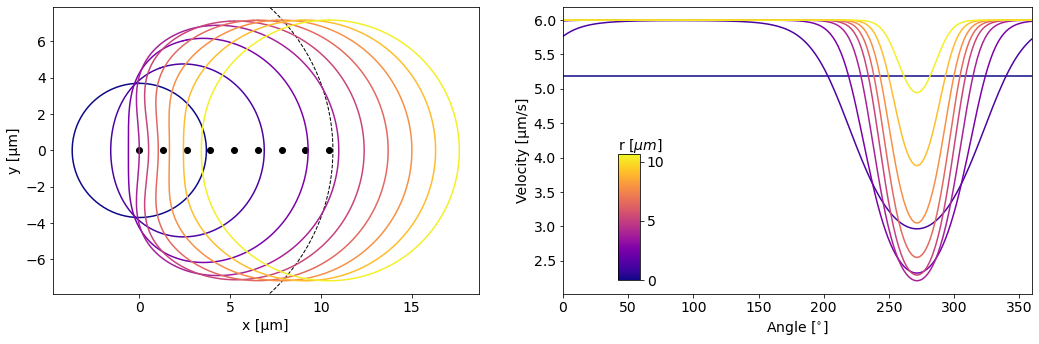

In [21]:
fig, ax = plt.subplots(figsize=(15,5)) 
#fig.suptitle(r'$\tau_{r} = $'+str(taur)+' s - boundary factor = '+str(boundaryparameter), fontsize=16)

ax1 = plt.subplot(1,2,1)                  #plot rings
colorwave = cm.plasma(np.linspace(0, 1, vprofilesteps))
circle2 = plt.Circle((0, 0), boundaryradius, color='k',linestyle='--', fill=False)
ax1.add_artist(circle2)
test = 6
for i in range(vprofilesteps):
    if i % 6 == 0:
        ax1.scatter(rwave[i],0,color='k')
        ax1.plot(importantsteps[test,i,:,1],importantsteps[test,i,:,0],c=colorwave[i])
        ax1.plot([importantsteps[test,i,-1,1],importantsteps[test,i,0,1]],[importantsteps[test,i,-1,0],importantsteps[test,i,0,0]],c=colorwave[i])
ax1.set_aspect('equal')
value = 1.1*boundaryradius
#ax1.set_xlim(-3,value)
#ax1.set_ylim(-8,8)
ax1.set_xlabel('x [µm]')
ax1.set_ylabel('y [µm]')
#ax1.set_title('Travel circles')
        
ax2 = plt.subplot(1,2,2)                  #plotv profiles
anglewave = np.linspace(0,360,steps)
for i in range(vprofilesteps):
    if i % 6 == 0:
        ax2.plot(anglewave,importantsteps[test,i,:,3],c=colorwave[i])
ax2.set_xlabel(r'Angle [$^{\circ}$]')
ax2.set_ylabel('Velocity [µm/s]') 
ax2.set_xlim(0,360)
#ax2.set_title('Velocity profiles')

plt.tight_layout() 
data = np.linspace(rwave[0], rwave[-1], vprofilesteps).reshape(vprofilesteps, 1)
im = ax.imshow(data, cmap='plasma')
divider = make_axes_locatable(ax)
cax = fig.add_axes([0.6, 0.2, 0.02, 0.35])
plt.colorbar(im, cax=cax)
plt.text(0,11,r'r [$\mu m$]')
plt.savefig('Fig3.pdf', format='pdf')
plt.show()

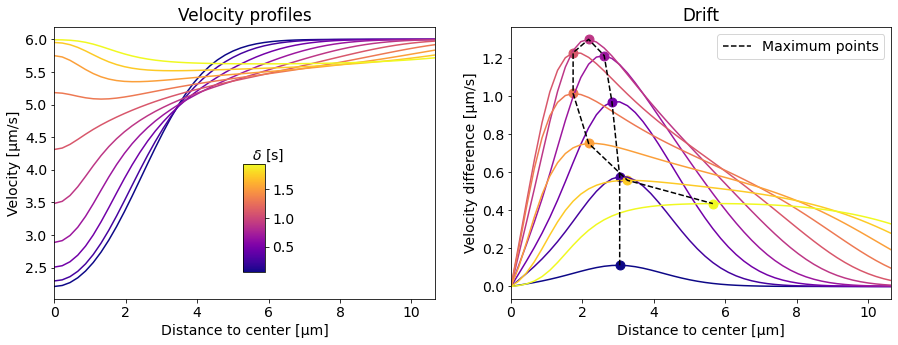

In [22]:
fig, ax = plt.subplots(figsize=(15,5)) 
#fig.suptitle(r'$\tau_{r} = $'+str(taur)+' s - boundary factor = '+str(boundaryparameter), fontsize=16)

ax2 = plt.subplot(1,2,1)                  #plot rings
colorwave = cm.plasma(np.linspace(0, 1, number))
for i in range(number): ax2.plot(rwave,vprofiles[i,:,0],color=colorwave[i],label = 'delay = '+str(round(delayarray[i],2))+'s')
ax2.set_xlabel('Distance to center [µm]')
ax2.set_ylabel('Velocity [µm/s]') 
ax2.set_title('Velocity profiles')
ax2.set_xlim(0,boundaryradius)

data = np.linspace(delayarray[0], delayarray[-1], number).reshape(number, 1)
im = ax.imshow(data, cmap='plasma')
divider = make_axes_locatable(ax2)
cax = fig.add_axes([0.3, 0.2, 0.02, 0.3])
plt.colorbar(im, cax=cax)
plt.text(0.8,2,r'$\delta$ [s]')
        
ax3 = plt.subplot(1,2,2)                  #plotv profiles
for i in range(number):
    ax3.plot(rwave,vprofiles[i,:,3],color=colorwave[i])
    ax3.scatter(maxpoints[i,0],maxpoints[i,1],s=80,color=colorwave[i])
ax3.plot(maxpoints[:,0],maxpoints[:,1],color='k',linestyle='--',label = 'Maximum points')
ax3.set_xlabel('Distance to center [µm]')
ax3.set_ylabel('Velocity difference [µm/s]')
ax3.set_title('Drift')
ax3.set_xlim(0,boundaryradius)
ax3.legend()

plt.savefig('Fig4.pdf', format='pdf')
plt.show()

<ipython-input-23-fdfc2fff47c6>:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


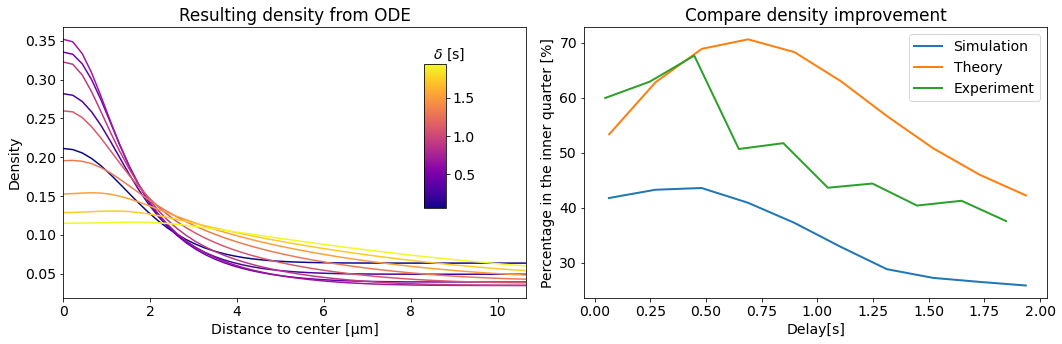

In [23]:
fig, ax = plt.subplots(figsize=(15,5)) 
#fig.suptitle(r'$\tau_{r} = $'+str(taur)+' s - boundary factor = '+str(boundaryparameter), fontsize=16)
colorwave = cm.plasma(np.linspace(0, 1, number))
ax4 = plt.subplot(1,2,1)                  #plot rings
for i in range(number): ax4.plot(rwave,savedensity2[:,i],c=colorwave[i])
ax4.set_xlabel('Distance to center [µm]')
ax4.set_ylabel('Density') 
ax4.set_title('Resulting density from ODE')
ax4.set_xlim(0,boundaryradius)

data = np.linspace(delayarray[0], delayarray[-1], number).reshape(number, 1)
im = ax.imshow(data, cmap='plasma')
divider = make_axes_locatable(ax4)
cax = fig.add_axes([0.4, 0.4, 0.02, 0.4])
plt.colorbar(im, cax=cax)
plt.text(0.8,2,r'$\delta$ [s]')
        
ax2 = plt.subplot(1,2,2)                  #plotv profiles
ax2.plot(simdelaywave,simdensity*100,linewidth=2,label='Simulation')
ax2.plot(delayarray,theodensity*100,linewidth=2,label='Theory')
ax2.plot(expdelaywave,expdensity*100,linewidth=2,label='Experiment')
ax2.set_xlabel('Delay[s]')
ax2.set_ylabel('Percentage in the inner quarter [%]')
ax2.set_title('Compare density improvement')
ax2.legend()

plt.tight_layout() 
plt.savefig('Fig5.pdf', format='pdf')
plt.show()

# Check influence of the strength of the flow

0
0
1
2
2
2
3
3
3
3
3


<ipython-input-28-5a76c0138fcb>:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


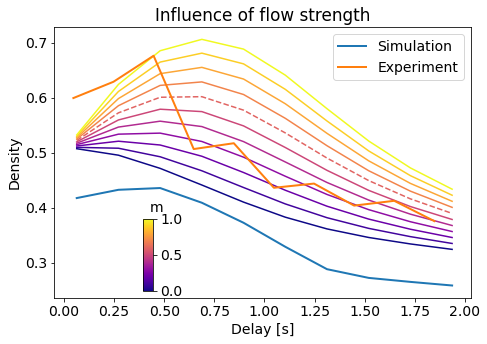

In [28]:
test = 11
theodensity = np.zeros((number,test))
strengtharray = np.linspace(0,1,test)

for j in range(test):
    strength = strengtharray[j]
    savedensity2 = np.zeros((vprofilesteps,number))
    for k in range(number):
        Darray = np.zeros(vprofilesteps)
        Darray = D_0 + vprofiles[k,:,0]**2*taur/4# + D_0
        c = np.zeros(vprofilesteps)        #array to save the density distributions
        c[0] = 1
        for i in range(vprofilesteps-1):
            #c[i+1] = c[i] * (1 - (Darray[i+1]-Darray[i]) / (2*Darray[i]))
            #c[i+1] = c[i] * (1 - (Darray[i+1]-Darray[i]) / (2*(Darray[i]-strength*vprofiles[k,i,3]**2*taur)))
            c[i+1] = c[i] * (1 - dx/Darray[i]*((Darray[i+1]-Darray[i])/(2*dx)+strength*vprofiles[k,i,3]))
            c[:] = c[:]/sum(abs(c[:])*dx)   #Normalize
        savedensity2[:,k] = c
    
    count = 0; check = True
    while check == True:
        if rwave[count] >= dataend: 
            check = False
            theoend = count
        else: count += 1
    theodx = rwave[1] - rwave[0]
    for i in range(number): theodensity[i,j] = sum(savedensity2[:theoend,i]*theodx)/sum(savedensity2[:,i]*theodx)

delaytime = np.zeros(number)
for i in range(number):
    delay = 1 + 4*i
    delaytime[i] = iterationtime*1e-3*(delay-1)+dt/2+addtime 

fig=plt.figure(1, figsize = (7,5) )
ax1 = plt.subplot(1,1,1)
color = 'tab:green'
colorwave = cm.plasma(np.linspace(0, 1, test))
for i in range(test):
    if i != 6: ax1.plot(delaytime,theodensity[:,i],color=colorwave[i])#,label = str(0.1*i))
    else: ax1.plot(delaytime,theodensity[:,i],color=colorwave[i],linestyle='--')#,label = str(0.1*i))
    print(np.argmax(theodensity[:,i]))
ax1.plot(simdelaywave,simdensity,linewidth=2,label='Simulation')
ax1.plot(expdelaywave,expdensity,linewidth=2,label='Experiment')
ax1.set_xlabel('Delay [s]')
ax1.set_ylabel('Density')
#ax1.set_ylim([0,0.7])
ax1.legend(loc=1)
plt.title('Influence of flow strength')

data = np.linspace(strengtharray[0], strengtharray[-1], test).reshape(test, 1)
im = ax.imshow(data, cmap='plasma')
divider = make_axes_locatable(ax1)
cax = fig.add_axes([0.3, 0.17, 0.02, 0.2])
plt.colorbar(im, cax=cax)
plt.text(0.6,1.1,r'm')

plt.tight_layout() 
plt.savefig('Fig9.pdf', format='pdf')
plt.savefig('Flow strength.pdf', format='pdf')
plt.savefig('Flow strength.svg', format='svg')
plt.show()

# Check influence of the boundary parameter

In [25]:
test = 11
theodensity = np.zeros((number,test))
savemaxpoints = np.zeros((number,2,test))
savevprofiles = np.zeros((number,vprofilesteps,4,test))
testarray = np.linspace(0,1,test,endpoint=True)

for m in range(test):
    boundaryparametertest = testarray[m]
    driftparameter = testarray[m]
    everystep = np.zeros((maxdelay,vprofilesteps,steps,4))                    #every step on the path to the past position is saved
    importantsteps = np.zeros((number,vprofilesteps,steps,4))                 #just the steps of the wanted delays are saved
    everystep[0,:,:,0] = 0
    for i in range(vprofilesteps): everystep[0,i,:,1] = rwave[i]              #radial startposition
    for i in range(steps): everystep[:,:,i,2] = onestep*i                     #angular startposition
    for i in range(vprofilesteps):
        for j in range(steps):
            count = 0
            for p in range(1,maxdelay+1):
                dist = np.sqrt(pow(everystep[p-1,i,j,0],2)+pow(everystep[p-1,i,j,1],2))    #dist to center for every position
                if dist >= boundaryradius:                                                 #boundary condition - reflexion of v-profile
                    dist = 2*boundaryradius - boundaryparametertest*dist                       #v-profile is mirrored at the boundary
                everystep[p-1,i,j,3] = vactive*calcvelocitysingle(dist,sigma,vdiff,amplitude,vmin)  #calculate v for every position
                step = steplengththeory(dt,everystep[p-1,i,j,3],taur)                  #caclculate step length for every position
                if p < maxdelay:
                    everystep[p,i,j,0] = everystep[p-1,i,j,0] + np.cos(everystep[p-1,i,j,2]*np.pi/180)*step   #calculate new position
                    everystep[p,i,j,1] = everystep[p-1,i,j,1] + np.sin(everystep[p-1,i,j,2]*np.pi/180)*step
                if count < number:                                           #save just important steps
                    if p-1 == values[count]:
                        importantsteps[count,i,j,:4] = everystep[p-1,i,j,:4]
                        count += 1

    vprofiles = np.zeros((number,vprofilesteps,4))
    for i in range(number):
        for j in range(vprofilesteps):
            vprofiles[i,j,0] = np.mean(importantsteps[i,j,:,3])                        #calculate v profile
            vprofiles[i,j,1] = np.mean(importantsteps[i,j,int(vprofilesteps/2):,3])    #v moving outwards
            vprofiles[i,j,2] = np.mean(importantsteps[i,j,:int(vprofilesteps/2),3])    #v moving inwards
            vprofiles[i,j,3] = vprofiles[i,j,2] - vprofiles[i,j,1]                     #v difference
    savevprofiles[:,:,:,m] = vprofiles
            
    savedensity2 = np.zeros((vprofilesteps,number))             #solve the ODe to get the density from the D- and v_diff profiles
    for k in range(number):
        Darray = np.zeros(vprofilesteps)
        Darray = vprofiles[k,:,0]**2*taur/4# + D_0
        c = np.zeros(vprofilesteps)                             #array to save the density distributions
        c[0] = 1
        for i in range(0,vprofilesteps-1):
            #c[i+1] = c[i] * (1 - (Darray[i+1]-Darray[i]) / (2*Darray[i]))
            #c[i+1] = c[i] * (1 - (Darray[i+1]-Darray[i]) / (2*(Darray[i]-vprofiles[k,i,3]**2*taur)))
            c[i+1] = c[i] * (1 - dx/Darray[i]*((Darray[i+1]-Darray[i])/(2*dx)+driftparameter*vprofiles[k,i,3]))
            c[:] = c[:]/sum(abs(c[:])*dx)                       #Normalize
        savedensity2[:,k] = c                                   #saveit

    maxpoints = np.zeros((number,2))
    for i in range(number):                                     #find and save maximum points of the drift for every delay
        maxpoints[i,1] = max(vprofiles[i,:,3])
        check = np.argmax(vprofiles[i,:,3])
        maxpoints[i,0] = rwave[check]
    savemaxpoints[:,:,m] = maxpoints[:,:]
    print(m)

0
1
2
3
4
5
6
7
8
9
10


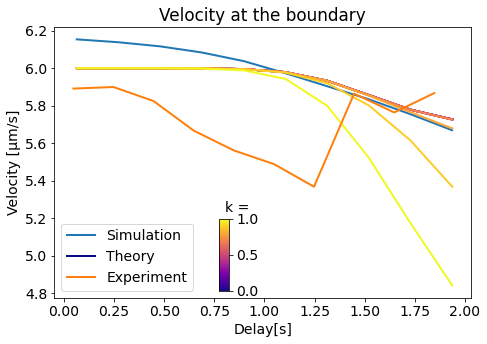

In [13]:
colorwave = cm.plasma(np.linspace(0, 1, test))
fig, ax = plt.subplots(figsize=(7,5)) 
ax2 = plt.subplot(1,1,1) 
ax2.plot(simdelaywave,simdataradial[-1,1,simfittingrow*simsteps:simfittingrow*simsteps+number],linewidth=2,label='Simulation')
for i in range(test):
    if i == 0: ax2.plot(delayarray,savevprofiles[:,-1,0,i],linewidth=2,label='Theory',color=colorwave[i])
    else: ax2.plot(delayarray,savevprofiles[:,-1,0,i],linewidth=2,color=colorwave[i])
ax2.plot(expdelaywave,expdataradial[-1,1,expfittingrow*expsteps:expfittingrow*expsteps+number],linewidth=2,label='Experiment')

ax2.set_xlabel('Delay[s]')
ax2.set_ylabel('Velocity [µm/s]')
ax2.set_title('Velocity at the boundary')
ax2.legend()
plt.tight_layout()
data = np.linspace(testarray[0], testarray[-1], test).reshape(test, 1)
im = ax.imshow(data, cmap='plasma')
divider = make_axes_locatable(ax1)
cax = fig.add_axes([0.45, 0.17, 0.02, 0.2])
plt.colorbar(im, cax=cax)
plt.text(0.6,1.1,r'k =')

plt.savefig('Fig6.pdf', format='pdf')
plt.show()

No handles with labels found to put in legend.


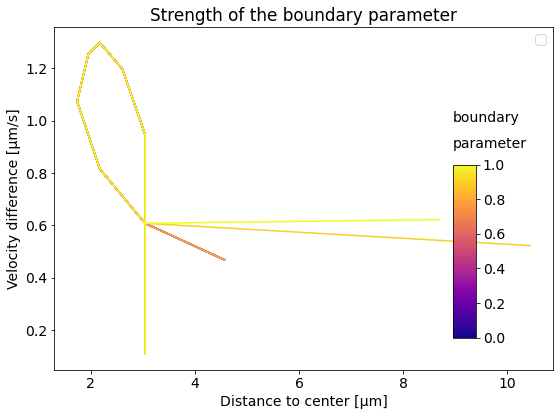

In [14]:
fig, ax = plt.subplots(figsize=(8,6)) 
ax1 = plt.subplot(1,1,1)  
colorwave = cm.plasma(np.linspace(0, 1, test))
for i in range(test):
    ax1.plot(savemaxpoints[:,0,i],savemaxpoints[:,1,i],color=colorwave[i])    
#ax1.plot(simmaxpoints[:,0],simmaxpoints[:,1],color='k',linestyle='dotted',label = 'Simulation',linewidth=2)    
#ax1.plot(expmaxpoints[:,0],expmaxpoints[:,1],color='k',label = 'Experiment',linewidth=2)

ax1.set_xlabel('Distance to center [µm]')
ax1.set_ylabel('Velocity difference [µm/s]')
#ax1.set_xlim([0,boundaryradius])
ax1.set_title('Maximum of the Drift')
ax1.legend()

plt.title('Strength of the boundary parameter')
plt.tight_layout() 
data = np.linspace(testarray[0], testarray[-1], number).reshape(number, 1)
im = ax.imshow(data, cmap='plasma')
divider = make_axes_locatable(ax3)
cax = fig.add_axes([0.8, 0.2, 0.04, 0.4])
plt.colorbar(im, cax=cax)
plt.text(0,1.25,'boundary')
plt.text(0,1.1,'parameter')

plt.savefig('Boundary parameter.pdf', format='pdf')
plt.savefig('Boundary parameter.svg', format='svg')
plt.show()


<ipython-input-15-5e714494cd2b>:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolor(x,y,field[:,:,3],zorder=-1)
<ipython-input-15-5e714494cd2b>:71: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax1.pcolor(x,y,field[:,:,3],zorder=-1)


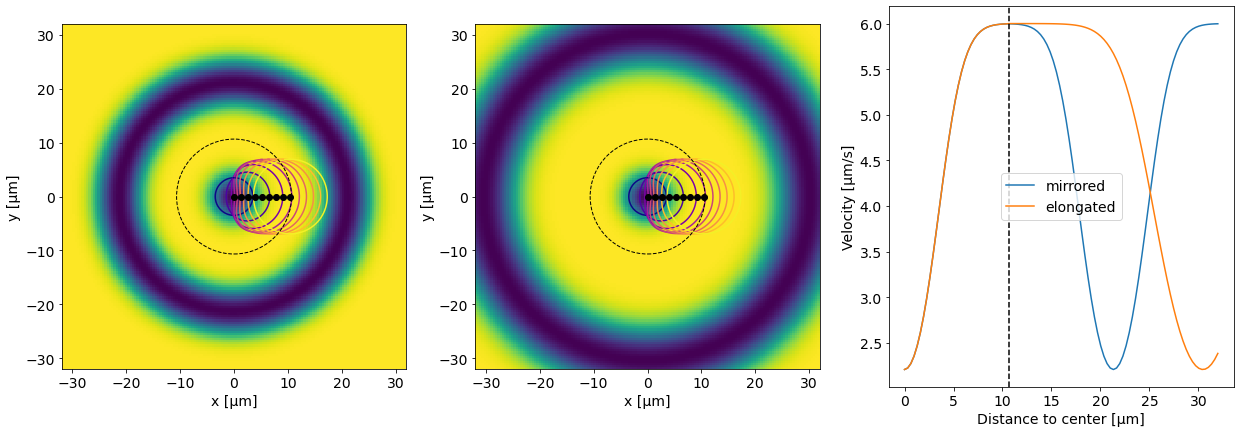

In [15]:
Nx = 201
steps = boundaryradius*8/Nx
field = np.zeros((Nx,Nx,4))

sigmaterm = 2*sigma**2
for i in range(Nx):          #Create v field - just for drawing
    field[:,i,0] = np.linspace(-4*boundaryradius,4*boundaryradius,Nx)
    field[i,:,1] = np.linspace(-4*boundaryradius,4*boundaryradius,Nx)
for i in range(Nx):
    for j in range(Nx):
        field[i,j,2] = np.sqrt(pow(field[i,j,0],2)+pow(field[i,j,1],2))
        if field[i,j,2] <= boundaryradius:
            I = amplitude*np.exp(-field[i,j,2]**2/sigmaterm)
            field[i,j,3] = vactive*vdiff*np.exp(-I/amplitude)+vmin
        else: 
            field[i,j,2] = 2*boundaryradius - field[i,j,2] 
            I = amplitude*np.exp(-field[i,j,2]**2/sigmaterm)
            field[i,j,3] = vactive*vdiff*np.exp(-I/amplitude)+vmin

fig=plt.figure(1, figsize = (21,7) )
ax = plt.subplot(1,3,1)
ax.set_aspect('equal')
colorwave = cm.plasma(np.linspace(0, 1, vprofilesteps))
circle2 = plt.Circle((0, 0), boundaryradius, color='k',linestyle='--', fill=False,zorder=-1)
ax.add_artist(circle2)
test = 6
for i in range(vprofilesteps):
    if i % 6 == 0:
        ax.scatter(rwave[i],0,color='k')
        ax.plot(importantsteps[test,i,:,1],importantsteps[test,i,:,0],c=colorwave[i],zorder=-1)
        ax.plot([importantsteps[test,i,-1,1],importantsteps[test,i,0,1]],[importantsteps[test,i,-1,0],importantsteps[test,i,0,0]],c=colorwave[i])
 
y, x = np.mgrid[slice(-4*boundaryradius, 4*boundaryradius, steps),
                slice(-4*boundaryradius, 4*boundaryradius, steps)]
im = ax.pcolor(x,y,field[:,:,3],zorder=-1)
value = 3*boundaryradius
ax.set_xlim(-value,value)
ax.set_ylim(-value,value)
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')

field = np.zeros((Nx,Nx,4))
for i in range(Nx):          #Create v field - just for drawing
    field[:,i,0] = np.linspace(-4*boundaryradius,4*boundaryradius,Nx)
    field[i,:,1] = np.linspace(-4*boundaryradius,4*boundaryradius,Nx)
for i in range(Nx):
    for j in range(Nx):
        field[i,j,2] = np.sqrt(pow(field[i,j,0],2)+pow(field[i,j,1],2))
        if field[i,j,2] <= boundaryradius:
            I = amplitude*np.exp(-field[i,j,2]**2/sigmaterm)
            field[i,j,3] = vactive*vdiff*np.exp(-I/amplitude)+vmin
        else: 
            field[i,j,2] = 2*boundaryradius - 0.7*field[i,j,2] 
            I = amplitude*np.exp(-field[i,j,2]**2/sigmaterm)
            field[i,j,3] = vactive*vdiff*np.exp(-I/amplitude)+vmin

ax1 = plt.subplot(1,3,2)
ax1.set_aspect('equal')
colorwave = cm.plasma(np.linspace(0, 1, vprofilesteps))
circle2 = plt.Circle((0, 0), boundaryradius, color='k',linestyle='--', fill=False,zorder=-1)
ax1.add_artist(circle2)
test = 6
for i in range(vprofilesteps):
    if i % 6 == 0:
        ax1.scatter(rwave[i],0,color='k')
        ax1.plot(importantsteps[test,i,:,1],importantsteps[test,i,:,0],c=colorwave[i],zorder=-1)
        ax1.plot([importantsteps[test,i,-1,1],importantsteps[test,i,0,1]],[importantsteps[test,i,-1,0],importantsteps[test,i,0,0]],c=colorwave[i])
 
y, x = np.mgrid[slice(-4*boundaryradius, 4*boundaryradius, steps),
                slice(-4*boundaryradius, 4*boundaryradius, steps)]
im = ax1.pcolor(x,y,field[:,:,3],zorder=-1)
value = 3*boundaryradius
ax1.set_xlim(-value,value)
ax1.set_ylim(-value,value)
ax1.set_xlabel('x [µm]')
ax1.set_ylabel('y [µm]')

size = 100
pltarray = np.zeros((100,3))
pltarray[:,0] = np.linspace(0,3*boundaryradius,size)
for i in range(size):
    dist1 = pltarray[i,0]
    dist2 = pltarray[i,0]
    if pltarray[i,0] >= boundaryradius:
        dist1 = 2*boundaryradius - pltarray[i,0]
        dist2 = 2*boundaryradius - 0.7*pltarray[i,0]
    I1 = amplitude*np.exp(-dist1**2/sigmaterm)
    pltarray[i,1] = vactive*vdiff*np.exp(-I1/amplitude)+vmin
    I2 = amplitude*np.exp(-dist2**2/sigmaterm)
    pltarray[i,2] = vactive*vdiff*np.exp(-I2/amplitude)+vmin
    
#cb = fig.colorbar(im, ax=ax1)
#cb.set_label(r'$v$ [µm/s]')
    
ax2 = plt.subplot(1,3,3)
ax2.plot(pltarray[:,0],pltarray[:,1],label='mirrored')
ax2.plot(pltarray[:,0],pltarray[:,2],label='elongated')
plt.axvline(x=boundaryradius,color='k',linestyle='--')
plt.xlabel('Distance to center [µm]')
plt.ylabel('Velocity [µm/s]')
plt.legend()


#plt.savefig('Fig1.pdf', format='pdf')
#plt.savefig('Fig1.svg', format='svg')
plt.show()